In [1]:
import os
os.chdir('..')

In [2]:
%pwd

'/home/deploy/ssd_keras'

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import json
from math import ceil
from slackclient import SlackClient
from tqdm import tqdm_notebook
from PIL import Image

from keras.optimizers  import Adam, SGD
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, Callback
from keras import backend as K
from keras.models import load_model

from models.keras_ssd300 import ssd_300
from keras_loss_function.keras_ssd_loss import SSDLoss
from keras_layers.keras_layer_AnchorBoxes import AnchorBoxes
from keras_layers.keras_layer_DecodeDetections import DecodeDetections
from keras_layers.keras_layer_DecodeDetectionsFast import DecodeDetectionsFast
from keras_layers.keras_layer_L2Normalization import L2Normalization

from ssd_encoder_decoder.ssd_input_encoder import SSDInputEncoder
from ssd_encoder_decoder.ssd_output_decoder import decode_detections, decode_detections_fast

from data_generator.object_detection_2d_data_generator import DataGenerator
from data_generator.object_detection_2d_geometric_ops import Resize
from data_generator.object_detection_2d_photometric_ops import ConvertTo3Channels
from data_generator.data_augmentation_chain_original_ssd import SSDDataAugmentation
from data_generator.object_detection_2d_misc_utils import apply_inverse_transforms

In [4]:
%matplotlib inline

In [5]:
image_dir = "image_data/train/"
annotation_file = 'tl_mapping_filter.csv'
train_csv = 'tl_train_filter.csv'

classes = {l.split(',')[0]: int(l.split(',')[1]) for l in 
           open(annotation_file).readlines()}
class_dict = {int(l.split(',')[1]): l.split(',')[0] for l in 
           open(annotation_file).readlines()}

In [6]:
K.clear_session()
model_path = 'snapshots/cur_best.h5'
ssd_loss = SSDLoss(neg_pos_ratio=3, alpha=1.0)
model = load_model(model_path, custom_objects={'AnchorBoxes': AnchorBoxes,
                                               'L2Normalization': L2Normalization,
                                               'compute_loss': ssd_loss.compute_loss})

In [7]:
img_height = 300
img_width = 300
normalize_coords = True
convert_to_3_channels = ConvertTo3Channels()
resize = Resize(height=img_height, width=img_width)

In [8]:
valid_dataset = DataGenerator(load_images_into_memory=False, hdf5_dataset_path=None,
                           labels_output_format=('class_id', 'xmin', 'ymin', 'xmax', 'ymax'))

valid_csv = 'tl_valid_filter.csv'

valid_dataset.parse_csv(image_dir, valid_csv, 
                 input_format=['image_name', 'xmin', 'ymin', 'xmax', 'ymax', 'class_id'])

In [9]:
valid_generator = valid_dataset.generate(batch_size=1,
                                         shuffle=True,
                                         transformations=[convert_to_3_channels,
                                                          resize],
                                         label_encoder=None,
                                         returns={'processed_images',
                                                  'filenames',
                                                  'inverse_transform',
                                                  'original_images',
                                                  'original_labels'},
                                         keep_images_without_gt=False)

In [18]:
pred = model.predict(
    np.expand_dims(np.array(Image.open(valid_dataset.filenames[0]).resize((300, 300))), axis=0)
)

In [19]:
decoded = decode_detections(pred,
                           confidence_thresh=0.5,
                           iou_threshold=0.4,
                           top_k=200,
                           normalize_coords=normalize_coords,
                           img_height=img_height,
                           img_width=img_width)

In [20]:
decoded

[array([[   4.        ,    0.69808048,  109.33983922,   41.46270901,
          204.38813567,  106.00488782],
        [   6.        ,    0.62737811,  145.47848403,  241.14162326,
          176.93472505,  277.1384418 ]])]

In [25]:
decoded[0][0]

array([   4.        ,    0.69808048,  109.33983922,   41.46270901,
        204.38813567,  106.00488782])

In [29]:
classes

{'Dress': 0,
 'Top': 1,
 'Pant': 2,
 'Skirt': 3,
 'Short': 4,
 'Denim': 5,
 'Shoe': 6,
 'Jumpsuit': 7,
 'Sweater': 8,
 'Jacket': 9,
 'Outerwear': 10}

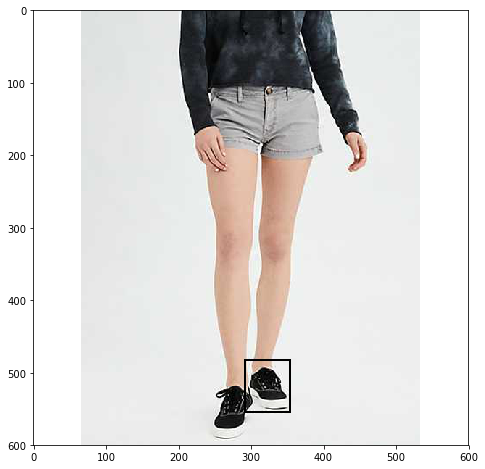

In [34]:
plt.figure(figsize=(8,8))
plt.imshow(np.array(Image.open(valid_dataset.filenames[0]).resize((600, 600))))

current_axis = plt.gca()

arr = decoded[0][1][2:]
arr = [x * 2 for x in arr]
current_axis.add_patch(plt.Rectangle((arr[0], arr[1]), arr[2]- arr[0], 
                         arr[3] - arr[1], fill=False, linewidth=2))

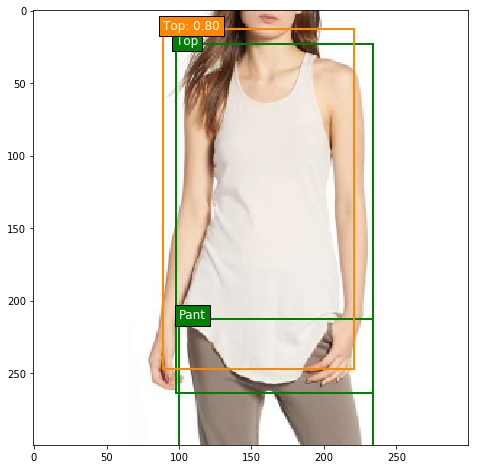

In [86]:
n_classes = len(classes)
colors = plt.cm.hsv(np.linspace(0, 1, n_classes+1)).tolist()

i = 0

plt.figure(figsize=(8,8))
plt.imshow(np.squeeze(processed_images[i], axis=0))

current_axis = plt.gca()

lbl = o_labels[i][0]
for box in lbl:
    xmin = box[1] / 2
    ymin = box[2] / 2
    xmax = box[3] / 2
    ymax = box[4] / 2
    label = '{}'.format(class_dict[int(box[0])])
    current_axis.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, 
                                         color='green', fill=False, linewidth=2))  
    current_axis.text(xmin, ymin, label, size='large', 
                      color='white', bbox={'facecolor':'green', 'alpha':1.0})

boxes = labels[i][0]
for box in boxes:
    xmin = int(box[2] / 2)
    ymin = int(box[3] / 2)
    xmax = int(box[4] / 2)
    ymax = int(box[5] / 2)
    color = colors[int(box[0])]
    label = '{}: {:.2f}'.format(class_dict[int(box[0])], box[1])
    current_axis.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, 
                                         ymax - ymin, color=color, fill=False, linewidth=2))  
    current_axis.text(xmin, ymin, label, size='large', 
                      color='white', bbox={'facecolor':color, 'alpha':1.0})